In [0]:
import os
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import random
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend, models
from tensorflow.keras.applications import MobileNet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image


In [5]:
# for colab use
!git clone https://github.com/amitf1/Birds_Classifier.git

Cloning into 'Birds_Classifier'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 42360 (delta 29), reused 49 (delta 17), pack-reused 42296
Receiving objects: 100% (42360/42360), 1.65 GiB | 63.61 MiB/s, done.
Resolving deltas: 100% (270/270), done.
Checking out files: 100% (70804/70804), done.


In [6]:
#paths of directories on colab. 
BASE_DIR = '/content/Birds_Classifier/data'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, '200_species_train')
VALIDATION_DIR = os.path.join(BASE_DIR, '200_species_valid')
TEST_DIR = os.path.join(BASE_DIR, '200_species_test')


BASE_DIR contains  ['200_species_train', '200_species_valid', '200_species_test', 'birds200_train', 'birds200_test', '200_species_consolidated']


In [7]:
#our categories.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)
Category_count = len(CATEGORIES)

200 CATEGORIES are  ['RED FACED CORMORANT', 'ALBATROSS', 'KILLDEAR', 'RAINBOW LORIKEET', 'ROBIN', 'BROWN THRASHER', 'GLOSSY IBIS', 'WILSONS BIRD OF PARADISE', 'WATTLED CURASSOW', 'D-ARNAUDS BARBET', 'INCA TERN', 'BELTED KINGFISHER', 'HOOPOES', 'AMERICAN KESTREL', 'BARN OWL', 'MASKED BOOBY', 'SPANGLED COTINGA', 'RAZORBILL', 'CASSOWARY', 'SPLENDID WREN', 'ANNAS HUMMINGBIRD', 'MIKADO  PHEASANT', 'AMERICAN BITTERN', 'BOBOLINK', 'BROWN NOODY', 'MALLARD DUCK', 'BLACK FRANCOLIN', 'AMERICAN REDSTART', 'TURKEY VULTURE', 'VERMILION FLYCATHER', 'GOLDEN PHEASANT', 'FLAMINGO', 'GOLD WING WARBLER', 'BAR-TAILED GODWIT', 'CRESTED CARACARA', 'AMERICAN AVOCET', 'BLUE HERON', 'ANTBIRD', 'MOURNING DOVE', 'GILA WOODPECKER', 'STORK BILLED KINGFISHER', 'ROADRUNNER', 'JAVAN MAGPIE', 'GRAY PARTRIDGE', 'RED WINGED BLACKBIRD', 'CARMINE BEE-EATER', 'PURPLE SWAMPHEN', 'SORA', 'WHITE NECKED RAVEN', 'MANDRIN DUCK', 'GOLDEN EAGLE', 'WHITE CHEEKED TURACO', 'HOODED MERGANSER', 'ANHINGA', 'CALIFORNIA QUAIL', 'JABIRU', '

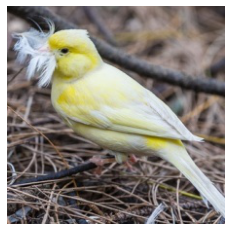

Figures are  (224, 224, 3)


In [8]:
#Load an image and determine image shape for analysis.
IMAGE = load_img(f"{TRAIN_DIR}/CANARY/001.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [0]:
#Normalization. This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
def load_dataset(data_path, max_species=200, shuffled=True, grayscale=False, flatten=False):
    data_images = []
    data_labels = []
    for num_species, specie in enumerate(os.listdir(data_path)):
        images_path = os.path.join(data_path, specie)
        for i in os.listdir(images_path):
            image_path = os.path.join(images_path, i)
            im = Image.open(image_path)
            if grayscale:
                im = im.convert("L")
            arr = np.asarray(im)
            if flatten:
                arr = arr.flatten()
            data_images.append(arr)
            data_labels.append(specie)
        if num_species == max_species - 1:
            break
    data_images = np.array(data_images)
    data_labels = np.array(data_labels)

    if shuffled:
        X, y = shuffle(data_images, data_labels, random_state=42)
    return tf.constant(X, dtype=float), tf.constant(y)

In [11]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data))
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))


# create also a regular dataset for convience in predicting later
X_val, y_val = load_dataset(VALIDATION_DIR)
X_val = X_val/255.0

Found 27503 images belonging to 200 classes.
data groups: 860
Found 1000 images belonging to 200 classes.
data groups: 32
validation image qty: 1000
Found 1000 images belonging to 200 classes.
data groups: 32


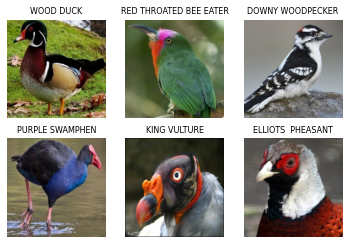

In [44]:
#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

In [13]:
#Let's try the mobilenet with ReduceLROnPlateau with augmentation 
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(Category_count)) 
model.add(Activation('softmax'))

model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
activation (Activation)      (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               10035400  
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
Total params: 13,264,264
Trainable params: 10,035,400
Non-trainable params: 3,228,864
_________________________________________________________________


In [0]:
#Compile
model.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [15]:
#fit model
history = model.fit( 
    train_data, 
    batch_size = 128, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

Epoch 1/50
860/860 [==============================] - 122s 142ms/step - loss: 11.7663 - accuracy: 0.6476 - val_loss: 5.3980 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 2/50
860/860 [==============================] - 121s 141ms/step - loss: 2.4493 - accuracy: 0.9223 - val_loss: 5.8933 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 3/50
860/860 [==============================] - ETA: 0s - loss: 1.7720 - accuracy: 0.9479
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
860/860 [==============================] - 121s 141ms/step - loss: 1.7720 - accuracy: 0.9479 - val_loss: 6.4288 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 4/50
860/860 [==============================] - 120s 140ms/step - loss: 0.8099 - accuracy: 0.9741 - val_loss: 5.6144 - val_accuracy: 0.8900 - lr: 7.0000e-04
Epoch 5/50
860/860 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.9784
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
860/860 [=========

In [16]:
# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


32/32 [==============================] - 4s 122ms/step - loss: 2.6447 - accuracy: 0.9430
Test loss: 2.644651174545288
Test accuracy: 0.9430000185966492


In [0]:
y_pred_val = model.predict(X_val)
enc = LabelEncoder()
y_val = enc.fit_transform(y_val)

In [0]:
y_preds = y_pred_val.argmax(axis=1)

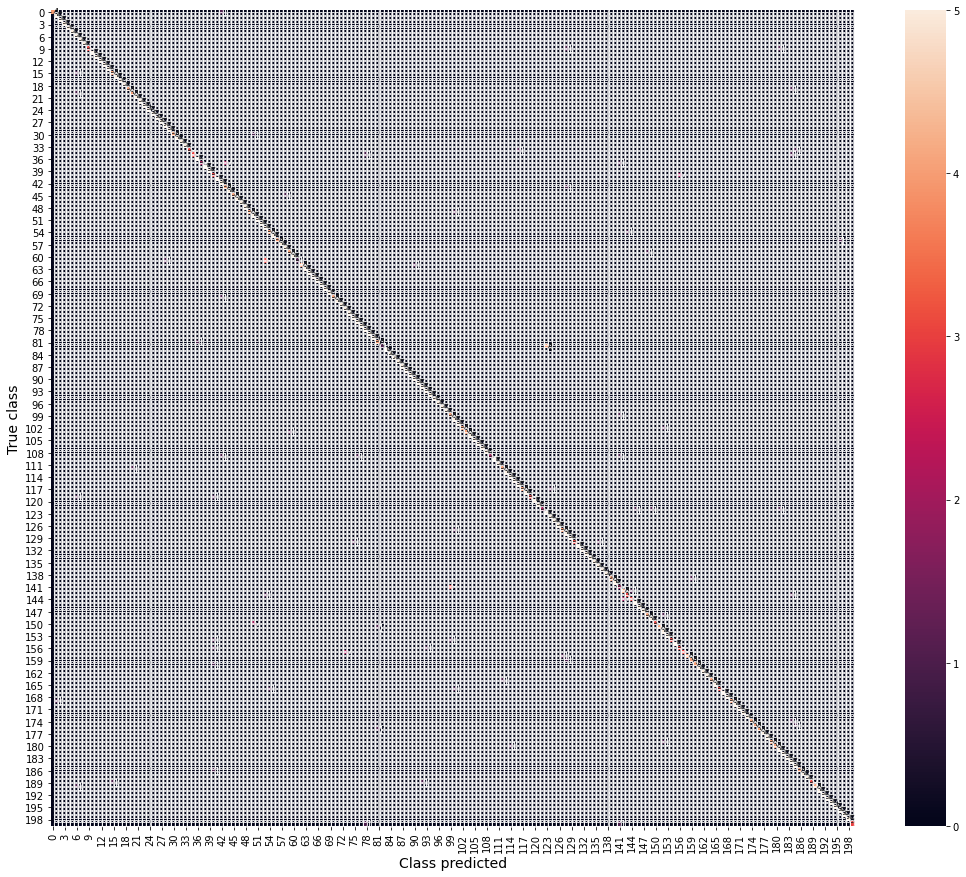

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.56      1.00      0.71         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       0.80      0.80      0.80         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [19]:
f = plt.figure(figsize=(18, 15))
sns.heatmap(confusion_matrix(y_val, y_preds), annot=True, fmt="3d")
plt.xlabel('Class predicted', fontsize=14)
plt.ylabel('True class', fontsize=14)
plt.show()

print(classification_report(y_val, y_preds))

In [20]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/model1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/model1/assets


**Model 2** 

Adding regularization to the model

In [30]:
#Let's try the mobilenet with ReduceLROnPlateau with augmentation 
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)
model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(200))
model.add(Dropout(0.2)) 
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
activation (Activation)      (None, 50176)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               10035400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0

In [0]:
#Compile
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.05),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [32]:
#fit model
history = model.fit( 
    train_data, 
    batch_size = 128, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

Epoch 1/50
860/860 [==============================] - 168s 196ms/step - loss: 867.4521 - accuracy: 0.4742 - val_loss: 299.3098 - val_accuracy: 0.8140 - lr: 0.0500
Epoch 2/50
860/860 [==============================] - 160s 186ms/step - loss: 286.5937 - accuracy: 0.7028 - val_loss: 300.0632 - val_accuracy: 0.8560 - lr: 0.0500
Epoch 3/50
860/860 [==============================] - ETA: 0s - loss: 191.4706 - accuracy: 0.7374
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.03500000052154064.
860/860 [==============================] - 157s 182ms/step - loss: 191.4706 - accuracy: 0.7374 - val_loss: 371.6104 - val_accuracy: 0.8690 - lr: 0.0500
Epoch 4/50
860/860 [==============================] - 165s 192ms/step - loss: 96.1483 - accuracy: 0.7684 - val_loss: 245.8763 - val_accuracy: 0.8970 - lr: 0.0350
Epoch 5/50
860/860 [==============================] - 158s 183ms/step - loss: 69.0967 - accuracy: 0.7752 - val_loss: 200.6904 - val_accuracy: 0.9090 - lr: 0.0350
Epoch 6/50
860/860 [==

In [0]:
y_pred_val = model.predict(X_val)
enc = LabelEncoder()
y_val = enc.fit_transform(y_val)

In [0]:
y_preds = y_pred_val.argmax(axis=1)

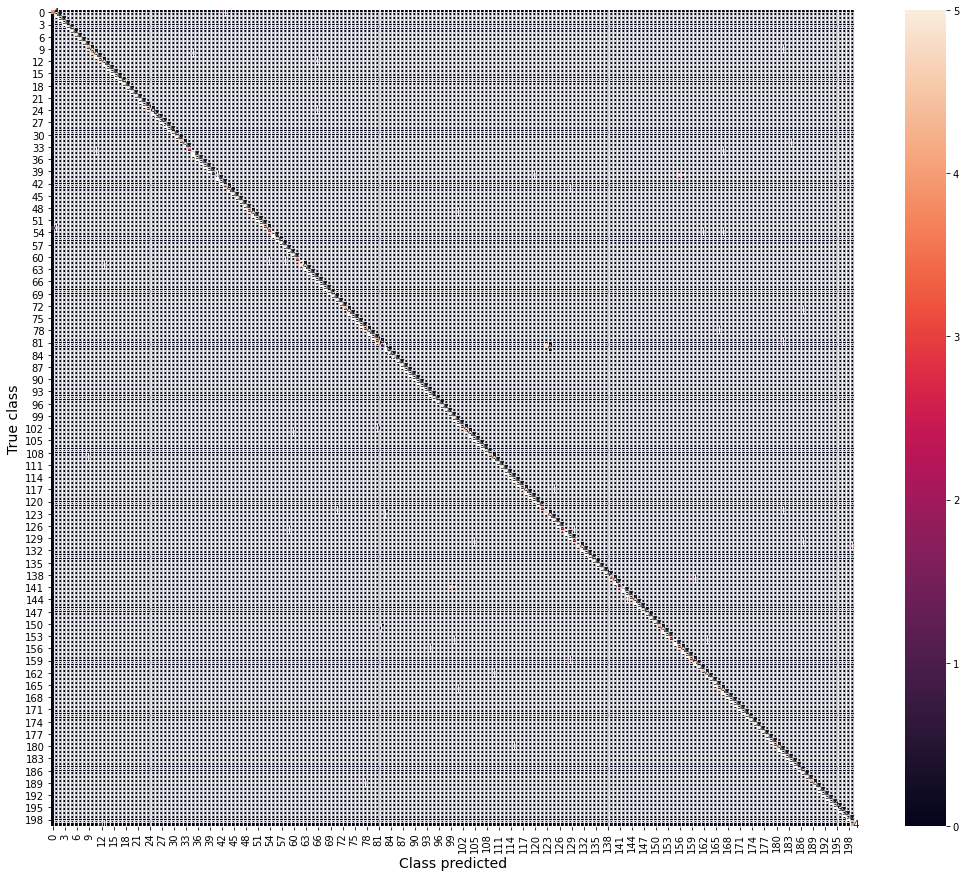

In [37]:
f = plt.figure(figsize=(18, 15))
sns.heatmap(confusion_matrix(y_val, y_preds), annot=True, fmt="3d")
plt.xlabel('Class predicted', fontsize=14)
plt.ylabel('True class', fontsize=14)
plt.show()

In [38]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.83      1.00      0.91         5
           9       1.00      0.80      0.89         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       0.67      0.80      0.73         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

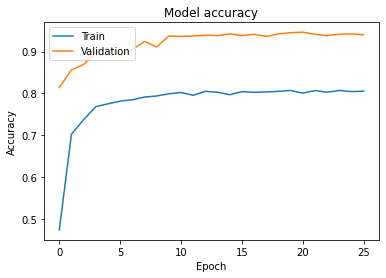

In [45]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

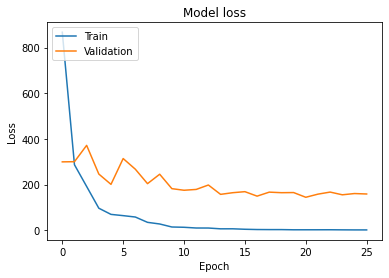

In [46]:
#plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

32/32 [==============================] - 5s 153ms/step - loss: 65.5154 - accuracy: 0.9630
Test loss: 65.51544952392578
Test accuracy: 0.9629999995231628


In [40]:
# Evaluate against train data.
scores = model.evaluate(train_data, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

860/860 [==============================] - 122s 142ms/step - loss: 0.0466 - accuracy: 1.0000
Train loss: 0.0465807244181633
Train accuracy: 0.999963641166687


In [41]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/model2')

INFO:tensorflow:Assets written to: saved_model/model2/assets


In [0]:
#download my saved models to my google drive
!cp -r saved_model drive/"My Drive"/